In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml

import torch
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.datasets.turb2D import Turb2D
from turboflow.quick_train import train

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import viz_utils as viz 
from turboflow.utils import file_utils as fle

import matplotlib.pyplot as plt
import cmocean

In [7]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','report_cominlabs_march2022')
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

base_dir.mkdir(parents=True, exist_ok=True)
base_dir.exists()

fig_path.mkdir(parents=True, exist_ok=True)
res_path.mkdir(parents=True, exist_ok=True)

(256, 256, 2)
(256, 256, 2)


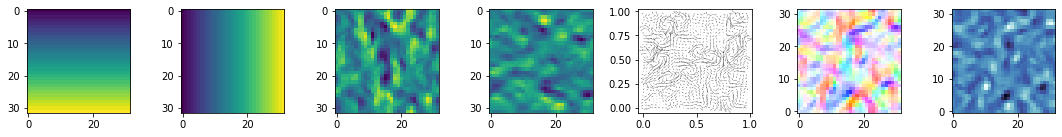

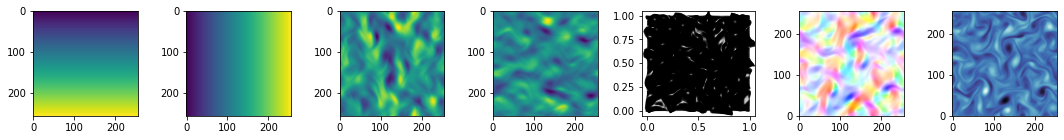

In [30]:
time_idx = 862
tb = Turb2D(data_dir)
tb.load_data(time_idx)

# Data in Turb2D are (T,R,R,D)
t = tb.t
xy = tb.xy
uv = tb.uv

print(xy.shape)
print(uv.shape)

# normalize y
uv = uv/np.max(np.abs(uv))
assert np.min(uv) >= -1
assert np.max(uv) <=  1

ds = 8

xy_sq_lr = xy[::ds,::ds,:]
uv_sq_lr = uv[::ds,::ds,:]
xy_sq_hr = xy
uv_sq_hr = uv

data = {
    'ongrid' : {
        'lr' : {'xy' : xy[::ds,::ds,:].reshape(-1,2), 
                'uv' : uv[::ds,::ds,:].reshape(-1,2), 
                'R'  : xy[::ds,::ds,:].shape[0]},
        'hr' : {'xy' : xy.reshape(-1,2), 
                'uv' : uv.reshape(-1,2), 
                'R'  : xy.shape[0]},
    }
}

for res in ['lr', 'hr']:
    R = data['ongrid'][res]['R']
    x = data['ongrid'][res]['xy'][...,0].reshape(R,R)
    y = data['ongrid'][res]['xy'][...,1].reshape(R,R)
    u = data['ongrid'][res]['uv'][...,0].reshape(R,R)
    v = data['ongrid'][res]['uv'][...,1].reshape(R,R)
    
    plt.figure(figsize=(15,2))
    plt.subplot(171)
    plt.imshow(x)
    plt.subplot(172)
    plt.imshow(y)
    plt.subplot(173)
    plt.imshow(u)
    plt.subplot(174)
    plt.imshow(v)
    
    plt.subplot(175)
    plt.quiver(x, y, u, v, scale=10, alpha=0.8)
    
    plt.subplot(176)
    img = viz.flow_to_image(data['ongrid'][res]['uv'].reshape(R,R,2))
    plt.imshow(img, origin='lower')
    
    plt.subplot(177)
    w = phy.compute_vorticity((x, y), (u, v))
    plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
    
    plt.tight_layout()
    plt.show()

(512, 512)
1.0
1.0
(262144, 2)
(262144, 2)


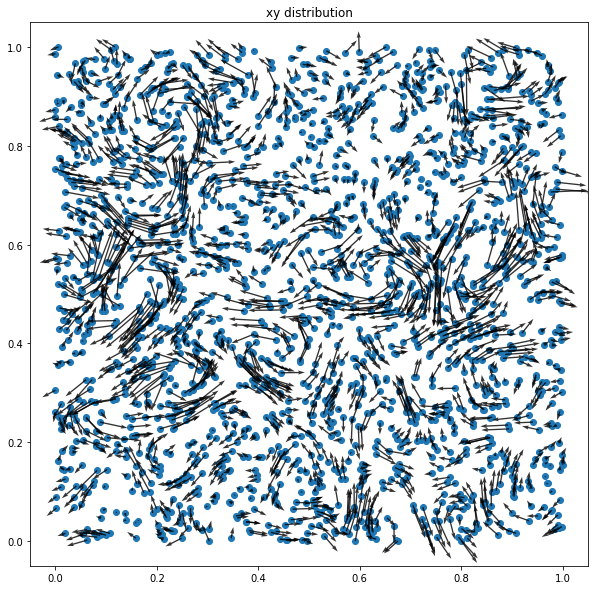

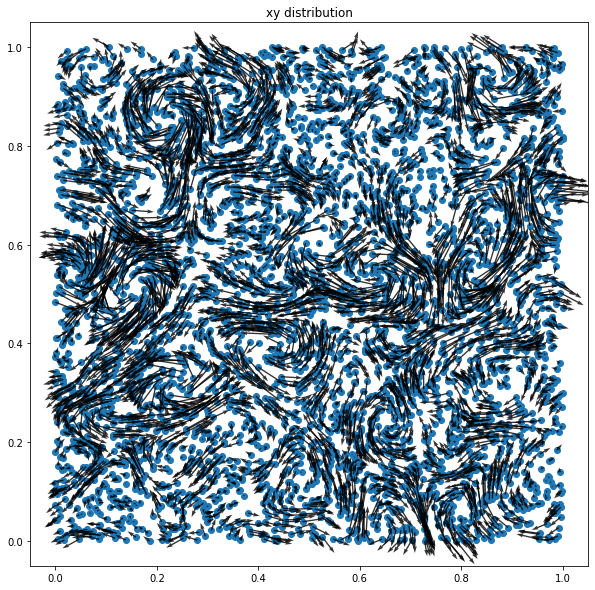

In [31]:
s=2
u_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,0], scale=s)
v_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,1], scale=s)

print(u_smp.shape)

xy_smp = np.stack([xy_smp[:,:,1], xy_smp[:,:,0]], axis=-1)
uv_smp = np.stack([u_smp, v_smp], axis=-1)


R_smp = uv_smp.shape[0]
xy_smp = xy_smp.reshape(R_smp**2, 2)
uv_smp = uv_smp.reshape(R_smp**2, 2)

uv_smp = uv_smp/np.max(np.abs(uv_smp))
print(np.max(np.abs(xy_smp)))
print(np.max(np.abs(uv_smp)))

print(uv_smp.shape)
print(xy_smp.shape)

max_res = 256

# subsample for TEST
ppp_test = 0.07
N_test = int((max_res**2) * ppp_test)
idx_test = np.random.randint(0, R_smp**2, size=N_test)

ppp_train = 0.03
N_train = int((max_res**2)*ppp_train)
idx_train = np.random.randint(0, R_smp**2, size=N_train)

data['offgrid'] = {
    'lr' : {'xy' :  xy_smp[idx_train,:], 'uv' : uv_smp[idx_train,:], 'R' : idx_train.shape[0]},
    'hr' : {'xy' :  xy_smp[idx_test,:],  'uv' : uv_smp[idx_test,:],  'R' : idx_test.shape[0]}
}


for res in ['lr', 'hr']:
    x = data['offgrid'][res]['xy'][...,0]
    y = data['offgrid'][res]['xy'][...,1]
    u = data['offgrid'][res]['uv'][...,0]
    v = data['offgrid'][res]['uv'][...,1]
    
    plt.figure(figsize=(10,10))
    plt.title('xy distribution')
    plt.scatter(x, y)
    
    ds = 1
    plt.quiver(x[::ds], y[::ds], u[::ds], v[::ds], scale=10, alpha=0.8)
    plt.show()

In [32]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, Cin = X.shape
        H, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H, Cin)
        y = y.reshape(H, Cout)
        
        self.size = H
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data):
        
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.batch_size = 125
        self.num_workers = 1
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)
    

dm = {}
for case in ['offgrid', 'ongrid']:
    print(case)
    dm[case] = DataModule(
        train_data= [data[case]['lr']['xy'], data[case]['lr']['uv']],
        val_data  = [data[case]['lr']['xy'], data[case]['lr']['uv']],
        test_data = [data[case]['hr']['xy'], data[case]['hr']['uv']],
    )

    dm[case].prepare_data()

offgrid
X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (4587, 2)
y shape (4587, 2)
torch.Size([4587, 2])
torch.Size([4587, 2])
ongrid
X shape (1024, 2)
y shape (1024, 2)
torch.Size([1024, 2])
torch.Size([1024, 2])
X shape (1024, 2)
y shape (1024, 2)
torch.Size([1024, 2])
torch.Size([1024, 2])
X shape (65536, 2)
y shape (65536, 2)
torch.Size([65536, 2])
torch.Size([65536, 2])


In [ ]:
exp_suffix = 'MVF_32x32x32_vanilla'
# train
train_params = {
    'batch_size' : { 'train' : 256,   'val'   : 256}
,   'dx' : {'train' : 8,   'val'   : 4 }
,   'dt' : {'train' : 8 ,   'val'   : 8}
,   'nt_train' : 32
,   'seed' : 438
,   'n_epoch' : 1000
}

model = {
    'name' : 'MFN' # 'RFFMLP
,   'cnn' : False
,   'do_divfree' : False
}

n_epoch = 5000
seed = 666
hparams = {
    'name': model['name'],
    'do_time' : True,
    'do_cnn' : model['cnn'],
    'mlp_layers_num': 1,
    'mlp_layers_dim': 32, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128,
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 1,
    'do_divfree': model['do_divfree'],
    'lam_sdiv': 0, 
    'lam_sfn':  0,    
    'lam_spec': 0,    
    'lam_grads':0,    
    'lam_curl' :0,    
    'lam_pde' : 0,
    'lam_weight': 1e-5,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

In [ ]:
model, best_model_path, hparams = train(exp_suffix, data_dir, hparams, train_params)
print(best_model_path.split('/')[-1])

In [ ]:
results = {
    'exp_name' : exp_suffix
,   'best_model_path' : best_model_path
,   'hparams' : hparams
}

results_path = res_path / Path(f'results_{exp_suffix}.yaml')
with open(results_path, 'w') as file:

    outputs = yaml.dump(results, file)

print('Done.')